In [14]:
# Install required packages
!pip install roboflow -q

# Import libraries
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
from collections import Counter

print("Libraries imported successfully!")

Libraries imported successfully!


In [15]:
from roboflow import Roboflow

# Initialize Roboflow
rf = Roboflow(api_key="REDACTED_FOR_SECURITY")

# Access the DentAi project
project = rf.workspace("daiant").project("dentai")

# Download version 2 in COCO format
print("📥 Downloading dataset from Roboflow...")
dataset = project.version(2).download("coco")

print(f" Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...
📥 Downloading dataset from Roboflow...
 Dataset downloaded to: /home/jupyter/DentAi-2


In [16]:
# Define dataset path
dataset_path = Path("/home/jupyter/DentAi-2")

# Check structure
print("📁 Dataset Structure:")
print(f"Dataset location: {dataset_path}")
print(f"Exists: {dataset_path.exists()}\n")

# List directories
splits = ['train', 'valid', 'test']
for split in splits:
    split_path = dataset_path / split
    if split_path.exists():
        # Count images (jpg files)
        images = list(split_path.glob("*.jpg"))
        # Check for annotation file
        annotation_file = split_path / "_annotations.coco.json"
        
        print(f"{split.upper()}:")
        print(f"  📸 Images: {len(images)}")
        print(f"  📋 Annotations: {'Yes' if annotation_file.exists() else '❌'}")

📁 Dataset Structure:
Dataset location: /home/jupyter/DentAi-2
Exists: True

TRAIN:
  📸 Images: 9159
  📋 Annotations: Yes
VALID:
  📸 Images: 370
  📋 Annotations: Yes
TEST:
  📸 Images: 243
  📋 Annotations: Yes


In [17]:
# Load and analyze annotations
def load_coco_annotations(json_path):
    """Load COCO format annotations and return categories and annotations"""
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data['categories'], data['annotations']

# Analyze train set
train_annotation_path = dataset_path / "train" / "_annotations.coco.json"
categories, annotations = load_coco_annotations(train_annotation_path)

# Create category mapping
category_map = {cat['id']: cat['name'] for cat in categories}

print("Dataset Classes:")
for cat_id, cat_name in category_map.items():
    print(f"  {cat_id}: {cat_name}")

# Count annotations per class
class_counts = Counter([ann['category_id'] for ann in annotations])

print(f"\nTraining Set Distribution:")
for cat_id, count in sorted(class_counts.items()):
    class_name = category_map[cat_id]
    print(f"  {class_name}: {count} annotations")

print(f"\nTotal annotations in training set: {len(annotations)}")

Dataset Classes:
  0: theeth-abnormalities
  1: Cavity
  2: Fillings
  3: Impacted Tooth
  4: Implant
  5: infected-teeth

Training Set Distribution:
  Cavity: 3456 annotations
  Fillings: 31434 annotations
  Impacted Tooth: 2568 annotations
  Implant: 10704 annotations
  infected-teeth: 10116 annotations

Total annotations in training set: 58278


✅ Valid Classes (5):
  Cavity: 3,456 (5.9%)
  Fillings: 31,434 (53.9%)
  Impacted Tooth: 2,568 (4.4%)
  Implant: 10,704 (18.4%)
  infected-teeth: 10,116 (17.4%)


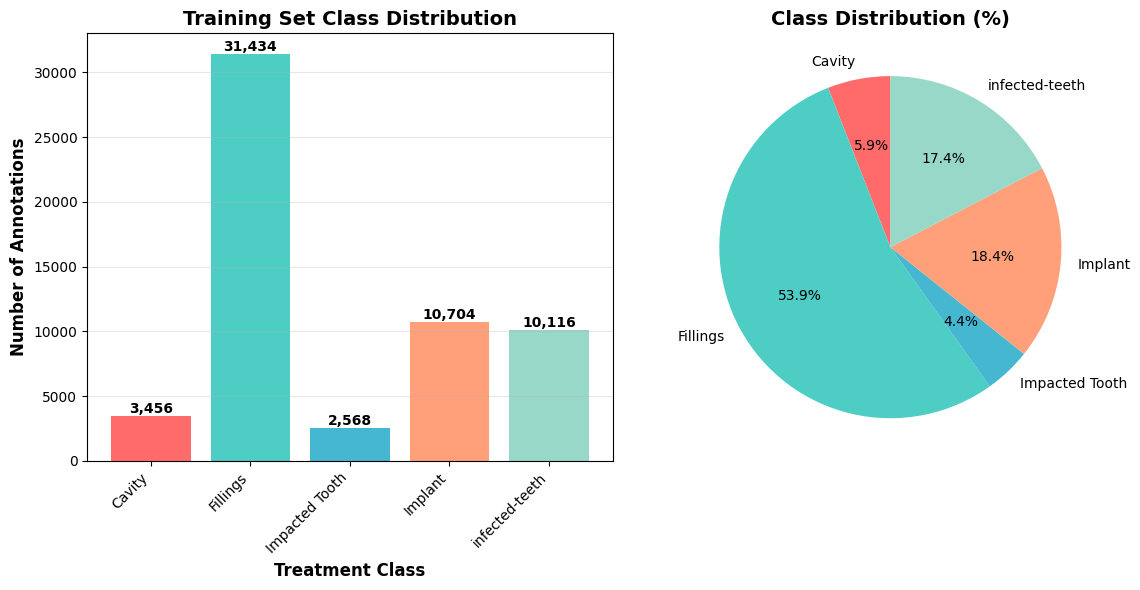


Chart saved as: class_distribution.png


In [18]:
# Filter out the empty class
valid_categories = [cat for cat in categories if cat['name'] != 'theeth-abnormalities']
valid_category_ids = [cat['id'] for cat in valid_categories]

# Update category map (only valid classes)
category_map = {cat['id']: cat['name'] for cat in valid_categories}

# Recount with valid classes only
valid_class_counts = {cat_id: count for cat_id, count in class_counts.items() 
                      if cat_id in valid_category_ids}

print("✅ Valid Classes (5):")
for cat_id, cat_name in category_map.items():
    count = valid_class_counts.get(cat_id, 0)
    percentage = (count / sum(valid_class_counts.values())) * 100
    print(f"  {cat_name}: {count:,} ({percentage:.1f}%)")

# Create visualization
plt.figure(figsize=(12, 6))

# Bar chart
class_names = [category_map[cat_id] for cat_id in sorted(valid_class_counts.keys())]
counts = [valid_class_counts[cat_id] for cat_id in sorted(valid_class_counts.keys())]

plt.subplot(1, 2, 1)
bars = plt.bar(class_names, counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'])
plt.xlabel('Treatment Class', fontsize=12, fontweight='bold')
plt.ylabel('Number of Annotations', fontsize=12, fontweight='bold')
plt.title('Training Set Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Pie chart
plt.subplot(1, 2, 2)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nChart saved as: class_distribution.png")

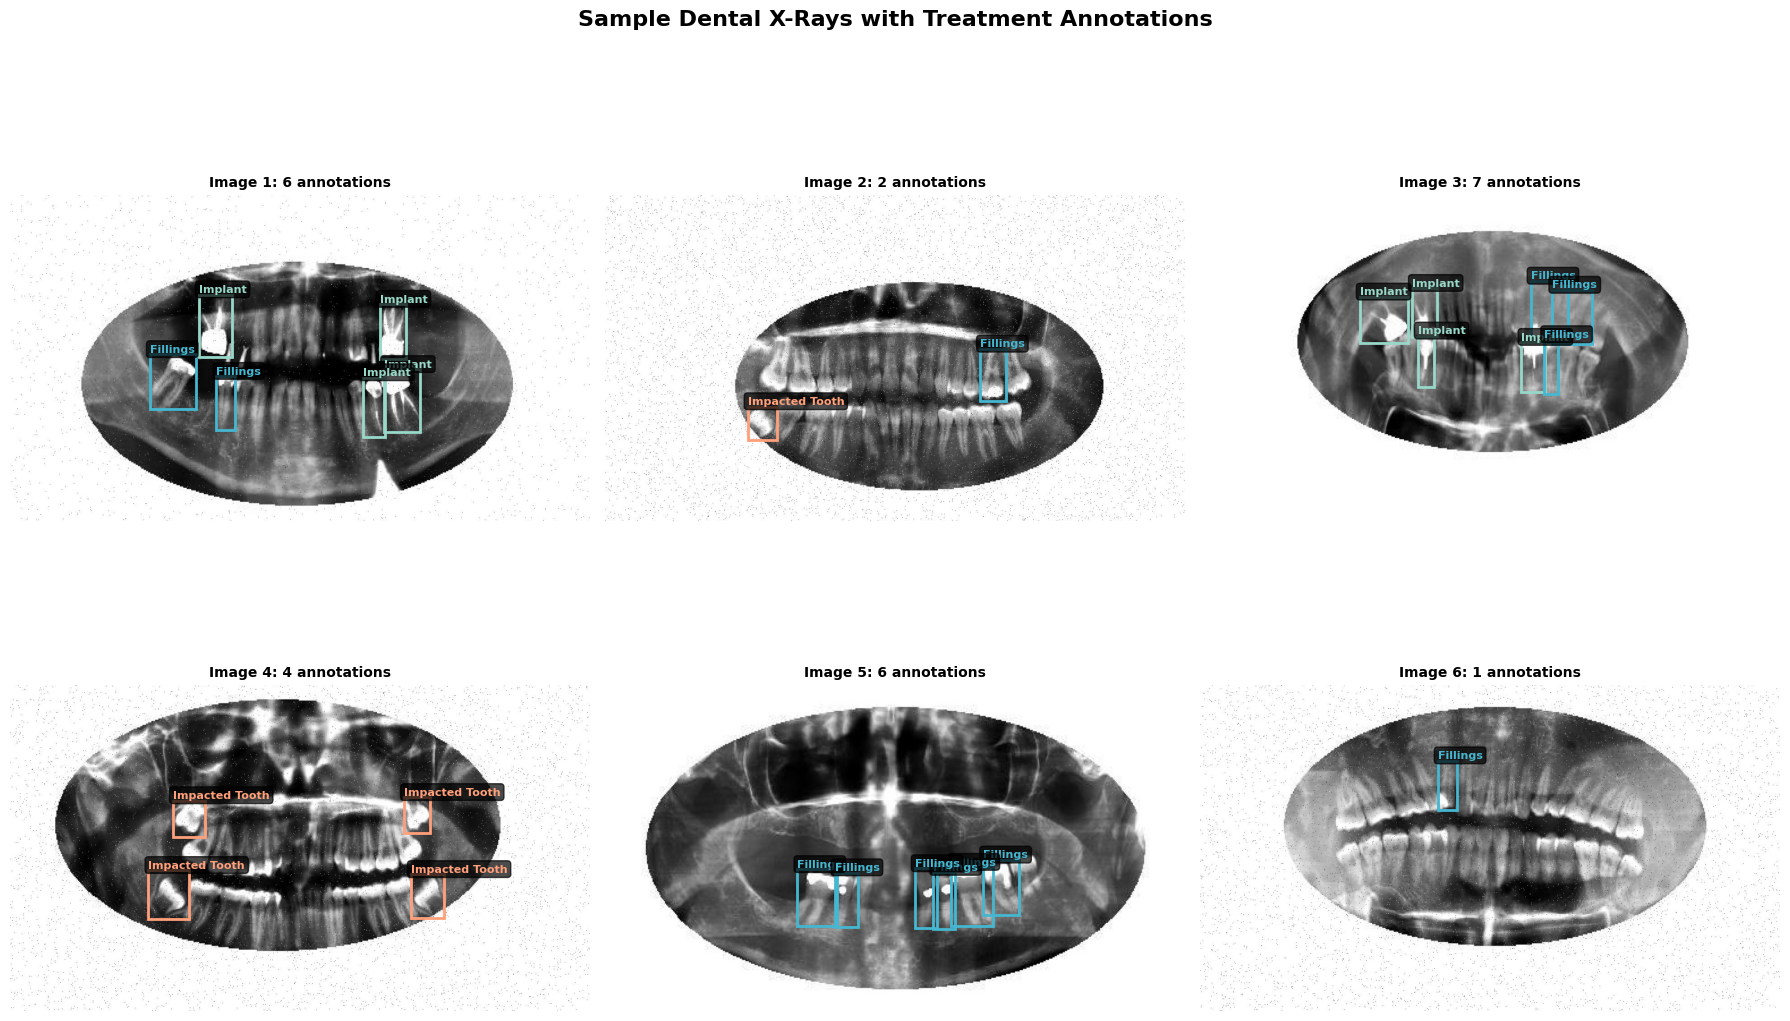

Visualization saved as: sample_annotations.png


In [19]:
import random

def visualize_sample_images(dataset_path, split='train', num_samples=6):
    """Display sample images with bounding boxes"""
    
    # Load annotations
    annotation_path = dataset_path / split / "_annotations.coco.json"
    with open(annotation_path, 'r') as f:
        coco_data = json.load(f)
    
    # Create image_id to annotations mapping
    image_annotations = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in image_annotations:
            image_annotations[img_id] = []
        image_annotations[img_id].append(ann)
    
    # Get images with annotations
    images_with_anns = [img for img in coco_data['images'] 
                        if img['id'] in image_annotations]
    
    # Sample random images
    sample_images = random.sample(images_with_anns, min(num_samples, len(images_with_anns)))
    
    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Color map for classes
    colors = {0: '#FF6B6B', 1: '#4ECDC4', 2: '#45B7D1', 3: '#FFA07A', 4: '#98D8C8'}
    
    for idx, img_info in enumerate(sample_images):
        # Load image
        img_path = dataset_path / split / img_info['file_name']
        img = Image.open(img_path)
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        
        # Draw bounding boxes
        for ann in image_annotations[img_info['id']]:
            # Skip invalid category IDs (like theeth-abnormalities)
            if ann['category_id'] not in category_map:
                continue
                
            bbox = ann['bbox']  # [x, y, width, height]
            class_name = category_map[ann['category_id']]
            color = colors.get(ann['category_id'], '#FFFFFF')
            
            # Create rectangle
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth=2, edgecolor=color, facecolor='none'
            )
            axes[idx].add_patch(rect)
            
            # Add label
            axes[idx].text(
                bbox[0], bbox[1] - 5, class_name,
                color=color, fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7)
            )
        
        axes[idx].set_title(f'Image {idx+1}: {len(image_annotations[img_info["id"]])} annotations',
                           fontsize=10, fontweight='bold')
    
    plt.suptitle('Sample Dental X-Rays with Treatment Annotations', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('sample_annotations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Visualization saved as: sample_annotations.png")

# Run visualization
visualize_sample_images(dataset_path, split='train', num_samples=6)

📊 Dataset Split:
  TRAIN: 9,159 images (93.7%)
  VALID: 370 images (3.8%)
  TEST: 243 images (2.5%)
  TOTAL: 9,772 images


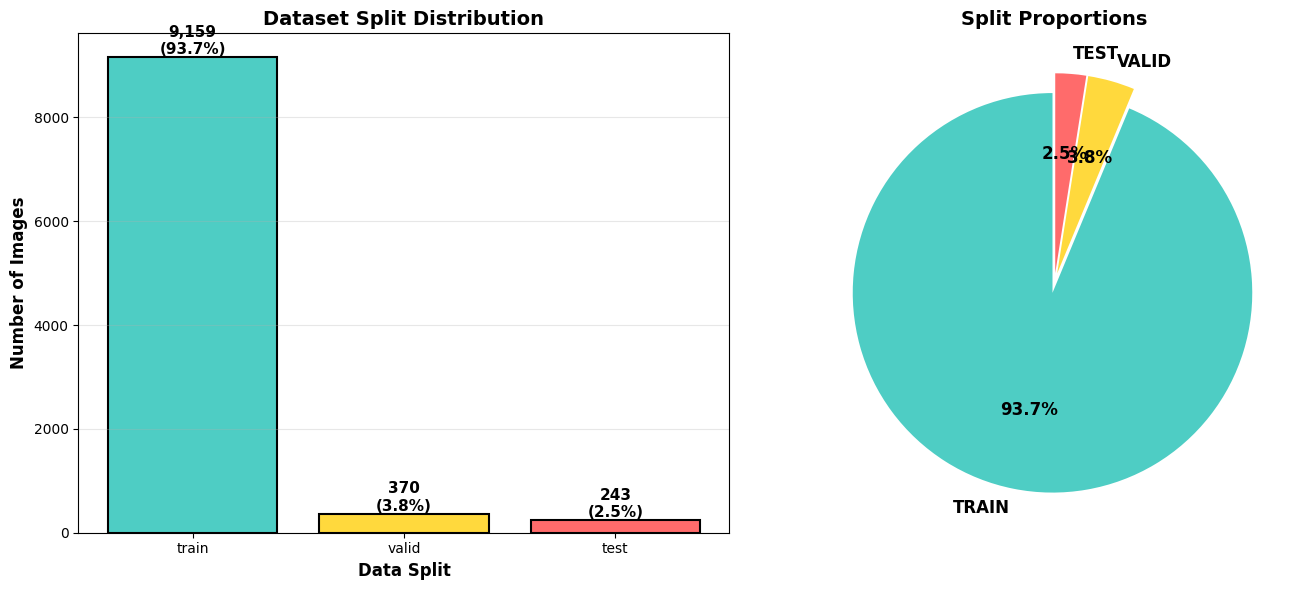


Chart saved as: dataset_split.png


In [20]:
# Count images in each split
split_counts = {}
for split in ['train', 'valid', 'test']:
    split_path = dataset_path / split
    images = list(split_path.glob("*.jpg"))
    split_counts[split] = len(images)

# Calculate percentages
total_images = sum(split_counts.values())
split_percentages = {k: (v/total_images)*100 for k, v in split_counts.items()}

print("📊 Dataset Split:")
for split, count in split_counts.items():
    percentage = split_percentages[split]
    print(f"  {split.upper()}: {count:,} images ({percentage:.1f}%)")
print(f"  TOTAL: {total_images:,} images")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
splits = list(split_counts.keys())
counts = list(split_counts.values())
colors_split = ['#4ECDC4', '#FFD93D', '#FF6B6B']

bars = ax1.bar(splits, counts, color=colors_split, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Data Split', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax1.set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar, count, pct in zip(bars, counts, [split_percentages[s] for s in splits]):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
ax2.pie(counts, labels=[s.upper() for s in splits], autopct='%1.1f%%', 
        startangle=90, colors=colors_split, explode=(0.05, 0.05, 0.05),
        textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Split Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('dataset_split.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nChart saved as: dataset_split.png")

In [21]:
# Function to clean COCO annotations
def clean_coco_annotations(json_path, output_path, excluded_categories):
    """Remove specified categories from COCO annotations"""
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Filter categories
    data['categories'] = [cat for cat in data['categories'] 
                         if cat['name'] not in excluded_categories]
    valid_cat_ids = [cat['id'] for cat in data['categories']]
    
    # Filter annotations
    data['annotations'] = [ann for ann in data['annotations'] 
                          if ann['category_id'] in valid_cat_ids]
    
    # Save cleaned version
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=2)
    
    return len(data['annotations'])

# Clean all splits
excluded = ['theeth-abnormalities']
print("Cleaning annotations (removing empty class)...\n")

for split in ['train', 'valid', 'test']:
    json_path = dataset_path / split / "_annotations.coco.json"
    output_path = dataset_path / split / "_annotations_cleaned.coco.json"
    
    ann_count = clean_coco_annotations(json_path, output_path, excluded)
    print(f"  {split.upper()}: {ann_count:,} annotations saved to _annotations_cleaned.coco.json")

print("Ready to upload to Google Cloud Storage")

🧹 Cleaning annotations (removing empty class)...

  TRAIN: 58,278 annotations saved to _annotations_cleaned.coco.json
  VALID: 2,098 annotations saved to _annotations_cleaned.coco.json
  TEST: 1,344 annotations saved to _annotations_cleaned.coco.json
Ready to upload to Google Cloud Storage
